<a href="https://colab.research.google.com/github/GunjanDhanuka/tomato-disease-classification/blob/main/tomato_disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
#Importing necessary libraries

import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#Checking the GPU being used in Colab
!nvidia-smi

Mon Aug 30 17:30:22 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P8    35W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
#Defining the constants for use in further code

IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 10

In [4]:
#Creating a dataset pipeline to read the images according to their classes directly through the file structure

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Projects/Tomato Disease Classification/PlantVillage",
    shuffle=True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 12768 files belonging to 8 classes.


In [6]:
#Our aim is to classify the leaf images into one of these 8 classes

class_names = dataset.class_names
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus']

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


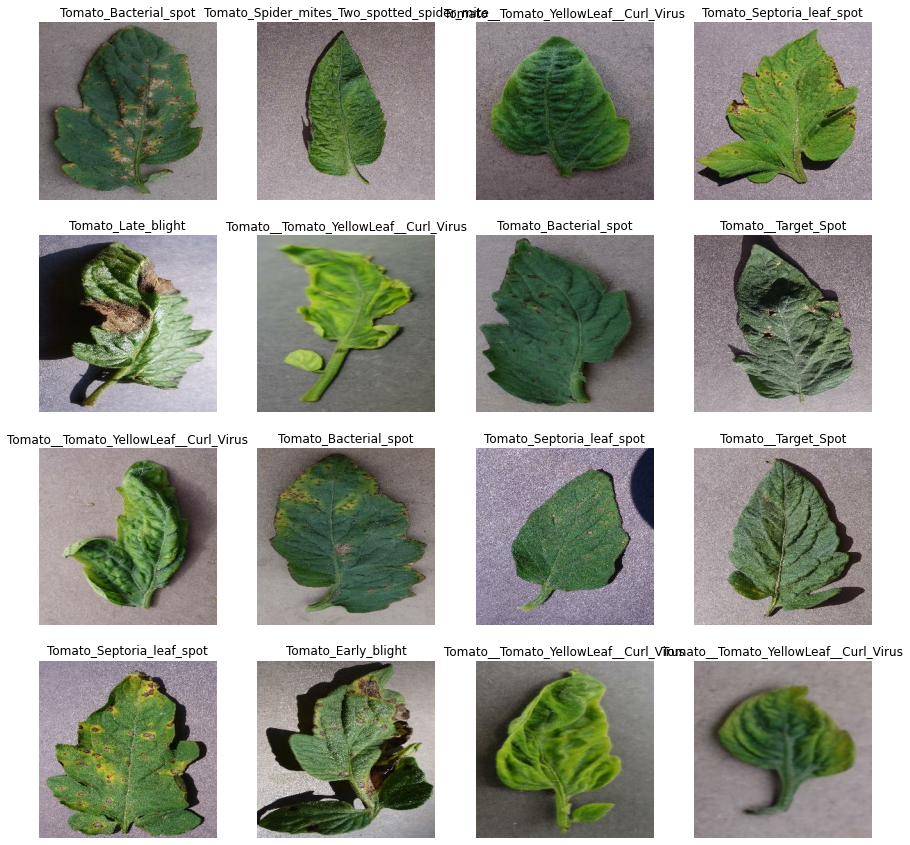

In [ ]:
#Plotting the labelled images in the training dataset
plt.figure(figsize=(15,15))
for image_batch, label_batch in dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4,4,i+1)
    plt.imshow(image_batch[i].numpy().astype('uint8'))
    plt.title(class_names[label_batch[i]])
    plt.axis('off')

In [ ]:
len(dataset)

399

In [7]:
def split_dataset(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=False, shuffle_size=10000):
  #Function to split the dataset into train-val-test divisions to ensure proper testing of the model
  #Shuffle is set to false due to the huge size of the dataset

  ds_size = len(ds)

  if(shuffle):
    ds = ds.shuffle(shuffle_size, seed=19)
  
  train_size = int(ds_size*train_split)
  val_size = int(ds_size*val_split)

  train_ds = ds.take(train_size)
  val_ds = ds.skip(train_size).take(val_size)
  test_ds = ds.skip(train_size).skip(val_size)

  return train_ds, val_ds, test_ds

In [9]:
train_ds, val_ds, test_ds = split_dataset(dataset)

In [10]:
len(test_ds)

41

In [11]:
# "cache" Reads the image from the disk and for the next iteration keeps it in the memory
#Thus speeds up the iterations

#"prefetch" makes CPU loads the next batch of examples while the GPU is busy training on the current batch

train_ds = train_ds.cache().prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds =  val_ds.cache().prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size = tf.data.AUTOTUNE)

In [12]:
#Image preprocessing

resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255),

])

In [13]:
#Data augmentation using Tensorflow layers

data_augmentation = tf.keras.Sequential([
         layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
                     layers.experimental.preprocessing.RandomRotation(0.2)                                
])

In [14]:

#Building the CNN Model
#TODO: Try to implement a popular architecture from a research paper

image_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 8
model = models.Sequential([
                           resize_and_rescale,
                           data_augmentation,
                           layers.Conv2D(32, (3,3), activation='relu', input_shape= image_shape),
                           layers.MaxPooling2D((2,2)),
                          layers.Conv2D(64, (3,3), activation='relu'),
                           layers.MaxPooling2D((2,2)),
                        layers.Conv2D(64, (3,3), activation='relu'),
                           layers.MaxPooling2D((2,2)),
                           layers.Conv2D(64, (3,3), activation='relu'),
                           layers.MaxPooling2D((2,2)),
                           layers.Conv2D(64, (3,3), activation='relu'),
                           layers.MaxPooling2D((2,2)),
                           layers.Flatten(),
                           layers.Dense(64, activation='relu'),
                           layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape = image_shape)

In [15]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 256, 256, 3)         0         
_________________________________________________________________
sequential_1 (Sequential)    (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (32, 60, 60, 64)         

In [16]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [17]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/10
319/319 [==============================] - 2646s 8s/step - loss: 1.5710 - accuracy: 0.4191 - val_loss: 1.1245 - val_accuracy: 0.6162
Epoch 2/10
319/319 [==============================] - 38s 120ms/step - loss: 0.8942 - accuracy: 0.6749 - val_loss: 0.7402 - val_accuracy: 0.7340
Epoch 3/10
319/319 [==============================] - 39s 123ms/step - loss: 0.6568 - accuracy: 0.7625 - val_loss: 0.6966 - val_accuracy: 0.7436
Epoch 4/10
319/319 [==============================] - 38s 119ms/step - loss: 0.5492 - accuracy: 0.8030 - val_loss: 0.6580 - val_accuracy: 0.7492
Epoch 5/10
319/319 [==============================] - 38s 119ms/step - loss: 0.4662 - accuracy: 0.8356 - val_loss: 0.4898 - val_accuracy: 0.8221
Epoch 6/10
319/319 [==============================] - 38s 119ms/step - loss: 0.4106 - accuracy: 0.8543 - val_loss: 0.4049 - val_accuracy: 0.8614
Epoch 7/10
319/319 [==============================] - 38s 119ms/step - loss: 0.3600 - accuracy: 0.8703 - val_loss: 0.4533 - val_acc

In [19]:
scores = model.evaluate(test_ds)

41/41 [==============================] - 274s 6s/step - loss: 0.2799 - accuracy: 0.9009


Thus, our model scores **90%** on the test dataset with only 10 epochs. Increasing the number of epochs may further boost the train and even the test accuracy.

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

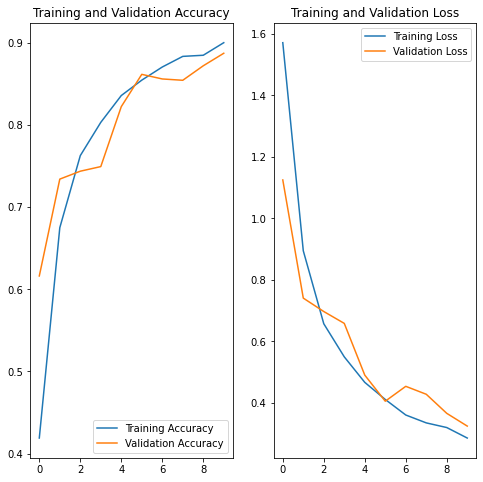

In [21]:
#Plotting the history of the model training

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

image to predict
Actual Label:  Tomato__Tomato_YellowLeaf__Curl_Virus
Predicted Label:  Tomato__Tomato_YellowLeaf__Curl_Virus


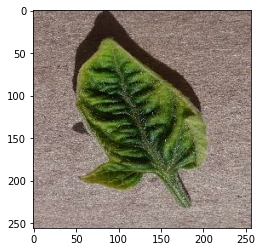

In [34]:
#Checking randomly the test images and if our model predicted the correct class
#Change the i to any index.

i = 4
for images_batch, labels_batch in test_ds.take(1):
  first_image = images_batch[i].numpy().astype('uint8')
  first_label = labels_batch[i].numpy()

  print("image to predict")
  plt.imshow(first_image)
  print("Actual Label: ", class_names[first_label])

  batch_prediction = model.predict(images_batch)
  print("Predicted Label: ", class_names[np.argmax(batch_prediction[i])])

In [36]:
#Exporting the model so that it can be used later on in an End-to-End Implementation

import os
model_version = max([int(i) for i in os.listdir("/content/drive/MyDrive/Projects/Tomato Disease Classification/models") + [0]])+1
model.save(f"/content/drive/MyDrive/Projects/Tomato Disease Classification/models/{model_version}")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Projects/Tomato Disease Classification/models/1/assets


In [38]:
#Define a function to predict the class of one single image given as input

def predict(model, img):
  img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array = tf.expand_dims(img_array, 0) #Creates a batch

  predictions = model.predict(img_array)

  predicted_class = class_names[np.argmax(predictions[0])]
  confidence = round(100* (np.max(predictions[0])), 2)

  return predicted_class, confidence

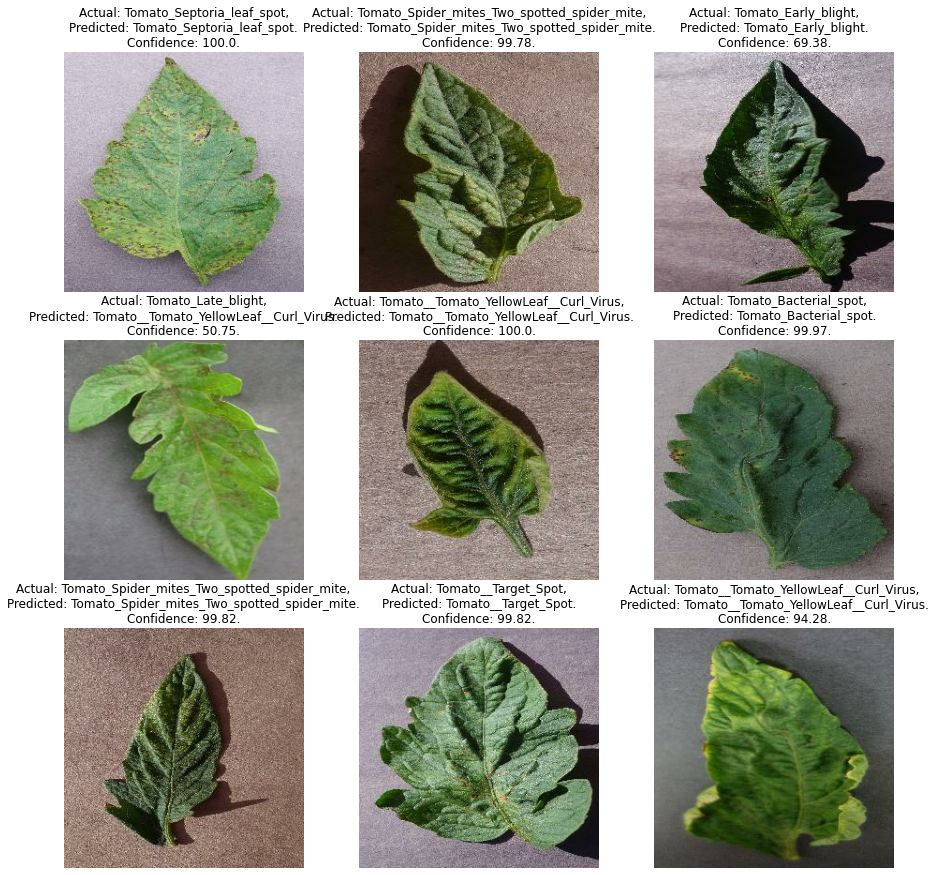

In [39]:
#See the predictions for some images from the test dataset

plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.axis('off')
    plt.imshow(images[i].numpy().astype('uint8'))

    predicted_class, confidence = predict(model, images[i].numpy())
    actual_class = class_names[labels[i]]

    plt.title(f"Actual: {actual_class},\nPredicted: {predicted_class}.\nConfidence: {confidence}.")